# FY4A的TOA随SZA变化

### 读取GeoNEX的FY4A数据

In [3]:
import numpy
import matplotlib.pyplot as plt
import xarray as xr

In [4]:
def read_fy4a_nc(nc_path, band_name, correct=10000.):
    ds = xr.open_dataset(nc_path)
    b1_dn = ds[band_name].values
    b1_array = numpy.array(b1_dn)
    real_data = b1_array/correct
    return real_data

In [222]:
# netCDF
nc_path = '/nfsdata01/GEO/FY4A/data/FY4A/FD/2021/2021.06.19/FY4A-_AGRI--_N_DISK_1047E_20210619030000.NC'

### 读取NIR的TOA发射率

In [223]:
# toa_nir = read_fy4a_nc(nc_path, 'Channel03') # nearest

In [224]:
toa_nir.shape # 数据范围 60°S-60°N，44°E-164°E

(12000, 12000)

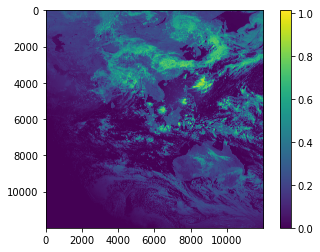

In [225]:
plt.imshow(toa_nir, interpolation=None)
plt.colorbar()

### 读取角度数据

In [52]:
# vza_fy4a = read_fy4a_nc(nc_path, 'NOMSatelliteZenith', 100.) # nearest

In [53]:
vza_fy4a.shape # 数据范围 60°S-60°N，44°E-164°E

(3000, 3000)

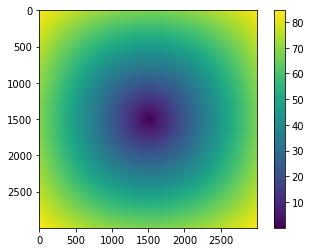

In [55]:
plt.imshow(vza_fy4a, interpolation=None)
plt.colorbar()

In [186]:
# sza_fy4a = read_fy4a_nc(nc_path, 'NOMSunZenith', 100.)

In [187]:
# vaa_fy4a = read_fy4a_nc(nc_path, 'NOMSatelliteAzimuth', 100.)
# saa_fy4a = read_fy4a_nc(nc_path, 'NOMSunAzimuth', 100.)

### 剪切至研究区

In [5]:
def clip_roi_fy4a(o_data, resolution, tlat, llon, size_degree):
    px_d = int(1./resolution)
    o_data = numpy.array(o_data)
    row = int((60-tlat)*px_d)
    col = int((llon-44)*px_d)
    size = int(size_degree/resolution)
    n_data = o_data[row:row+size, col:col+size]
    return n_data

In [175]:
# roi_toa_nir = clip_roi_fy4a(toa_nir, 0.01, -20.5, 129.5, 2)

In [177]:
# roi_vza_fy4a = clip_roi_fy4a(vza_fy4a, 0.04, -20.5, 129.5, 2)

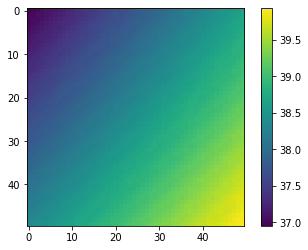

In [188]:
plt.imshow(roi_vza_fy4a, interpolation=None)
plt.colorbar()

### 计算RAA

In [6]:
def cal_raa(aa1, aa2):
    raa = 0
    diff = abs(aa1 - aa2)
    if diff < 180:
        raa = diff
    else:
        raa = 360 - diff
    return raa

In [194]:
# roi_vaa_fy4a = clip_roi_fy4a(vaa_fy4a, 0.04, -20.5, 129.5, 2)
# roi_saa_fy4a = clip_roi_fy4a(saa_fy4a, 0.04, -20.5, 129.5, 2)

In [195]:
# roi_raa_fy4a = numpy.zeros_like(roi_vaa_fy4a)
# for v_y in range(len(roi_vaa_fy4a)):
#     for v_x in range(len(roi_vaa_fy4a[0])):
#         vaa_px = roi_vaa_fy4a[v_y][v_x]
#         saa_px = roi_saa_fy4a[v_y][v_x]
#         roi_raa_fy4a[v_y][v_x] = cal_raa(vaa_px, saa_px)

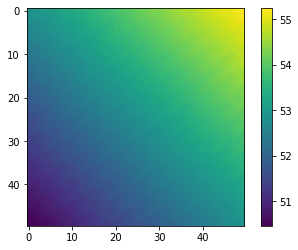

In [197]:
plt.imshow(roi_raa_fy4a, interpolation=None)
plt.colorbar()

### 插值角度数据

In [7]:
from scipy import interpolate

def fit_toa_geo(o_geo_array, toa_array):
    y_geo_s = numpy.linspace(0, 1, o_geo_array.shape[0])
    x_geo_s = numpy.linspace(0, 1, o_geo_array.shape[1])
    y_toa_s = numpy.linspace(0, 1, toa_array.shape[0])
    x_toa_s = numpy.linspace(0, 1, toa_array.shape[1])
    fun_geo = interpolate.interp2d(x_geo_s, y_geo_s, o_geo_array, kind='linear')
    n_geo_array = fun_geo(x_toa_s, y_toa_s)
    return n_geo_array

In [200]:
# raa_1km = fit_toa_geo(roi_raa_fy4a, roi_toa_nir)

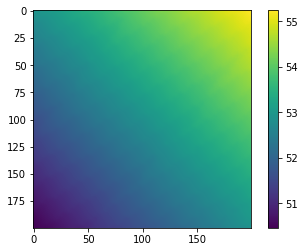

In [201]:
plt.imshow(raa_1km, interpolation=None)
plt.colorbar()

## 筛选符合条件的观测

In [8]:
import os
from datetime import datetime, timedelta

start_date_str = '2021-01-01T00:00:00Z'
end_date_str = '2021-12-31T23:59:59Z'
date_offset_d = timedelta(days=1)

fy4a_basic_path = '/nfsdata01/GEO/FY4A/data/FY4A/FD/2021'

end_date = datetime.strptime(end_date_str, "%Y-%m-%dT%H:%M:%SZ")

In [9]:
CAMS_PATH = '/data01/GEO/INPUT/ATMOSPHERE/'

def limit_AOT(obs_time, roi_tlat, roi_llon):
    obs_day = obs_time[:8]
    cams_nc_file = CAMS_PATH + '/' + obs_day + '.nc'
    
    obs_yy = int(obs_time[:4])
    obs_mm = int(obs_time[4:6])
    obs_dd = int(obs_time[6:8])
    obs_HH = int(obs_time[8:10])
    obs_MM = int(obs_time[10:])
    dtime = datetime(obs_yy, obs_mm, obs_dd, obs_HH, obs_MM)
    
    ds = xr.open_dataset(cams_nc_file)
    
    ds = ds.interp(time=dtime, method='linear')    
    ds = ds.interp(longitude=roi_llon, latitude=roi_tlat, method="nearest")
    
    AOT550 = ds['aod550'].values

    if AOT550 < 0.15:
        return 1
    return 0

In [10]:
def screen_data(obs_nc_filename, obs_time, record_array, roi_tlat=-20.5, roi_llon=129.5, roi_size_degree=0.08):
    print(obs_time)
    obs_day = obs_time[:8]
    obs_hm = obs_time[-4:]
    try:
        toa_nir = read_fy4a_nc(obs_nc_filename, 'Channel03')
        sza_fy4a = read_fy4a_nc(obs_nc_filename, 'NOMSunZenith', 100.)
        vaa_fy4a = read_fy4a_nc(obs_nc_filename, 'NOMSatelliteAzimuth', 100.)
        saa_fy4a = read_fy4a_nc(obs_nc_filename, 'NOMSunAzimuth', 100.)
    except Exception as e:
        print(e)
        return record_array
    
    # ROI
    roi_toa_nir = clip_roi_fy4a(toa_nir, 0.01,roi_tlat, roi_llon, roi_size_degree)
    roi_sza_fy4a = clip_roi_fy4a(sza_fy4a, 0.04, roi_tlat, roi_llon, roi_size_degree)
    roi_vaa_fy4a = clip_roi_fy4a(vaa_fy4a, 0.04, roi_tlat, roi_llon, roi_size_degree)
    roi_saa_fy4a = clip_roi_fy4a(saa_fy4a, 0.04, roi_tlat, roi_llon, roi_size_degree)
    
    roi_raa_fy4a = numpy.zeros_like(roi_vaa_fy4a)
    for v_y in range(len(roi_vaa_fy4a)):
        for v_x in range(len(roi_vaa_fy4a[0])):
            vaa_px = roi_vaa_fy4a[v_y][v_x]
            saa_px = roi_saa_fy4a[v_y][v_x]
            roi_raa_fy4a[v_y][v_x] = cal_raa(vaa_px, saa_px)
    raa_1km = fit_toa_geo(roi_raa_fy4a, roi_toa_nir)
    sza_1km = fit_toa_geo(roi_sza_fy4a, roi_toa_nir)
    
#     for v_y in range(len(raa_1km)):
#         for v_x in range(len(raa_1km[0])):
#             raa_v = raa_1km[v_y][v_x]
# #             if raa_v > 5. and raa_v < 35.:
#             if raa_v > 0. and raa_v < 90.:
#                 sza_v = sza_1km[v_y][v_x]
#                 toa_v = roi_toa_nir[v_y][v_x]
#                 if toa_v < 0.4:
#                     px_lat = roi_tlat - v_y*0.01
#                     px_lon = roi_llon + v_x*0.01
#                     if limit_AOT(obs_time, px_lat, px_lon):
#                         sza_v = round(sza_v, 3)
#                         raa_v = round(raa_v, 3)
                        
#                         record_array.append([sza_v, roi_toa_nir, raa_v])
    
    v_y = 0
    v_x = 0
    raa_v = raa_1km[v_y][v_x]
#     if raa_v > 90. and raa_v < 180.:
    if raa_v > 0. and raa_v < 90.:
        sza_v = sza_1km[v_y][v_x]
        toa_v = roi_toa_nir[v_y][v_x]
        if toa_v < 0.4:
            px_lat = roi_tlat - v_y*0.01
            px_lon = roi_llon + v_x*0.01
            if limit_AOT(obs_time, px_lat, px_lon):
                sza_v = round(sza_v, 3)
                raa_v = round(raa_v, 3)
                print(raa_v)
                record_array.append([sza_v, roi_toa_nir, raa_v])
                
    return record_array

In [11]:
# obs_utc_strs = ['0100', '0200']
obs_utc_strs = ['0200']
toa_sza_record = []
for obs_utc_str in obs_utc_strs:
    temp_date = datetime.strptime(start_date_str, "%Y-%m-%dT%H:%M:%SZ")
    while temp_date < end_date:
        folder_name = temp_date.strftime("%Y.%m.%d")
        file_day = temp_date.strftime("%Y%m%d")
        file_time = file_day + obs_utc_str
        file_name = 'FY4A-_AGRI--_N_DISK_1047E_' + file_time + '00.NC'
        nc_filename = fy4a_basic_path + '/' + folder_name + '/' + file_name

        if os.path.exists(nc_filename):
            screen_data(nc_filename, file_time, toa_sza_record)
            
        temp_date = temp_date + date_offset_d

202101010200
154.37
202101020200
154.07
202101030200
153.74
202101040200
153.39
202101050200
153.03
202101060200
152.64
202101070200
152.23
202101080200
151.81
202101090200
151.37
202101100200
150.91
202101110200
150.43
202101120200
149.94
202101130200
149.42
202101140200
148.9
202101150200
148.35
202101160200
147.79
202101170200
147.22
202101180200
146.63
202101190200
146.03
202101200200
145.41
202101210200
144.78
202101220200
202101230200
143.47
202101240200
202101250200
202101260200
141.42
202101270200
140.71
202101280200
202101290200
139.26
202101300200
138.52
202101310200
137.77
202102010200
202102020200
136.25
202102030200
135.47
202102040200
134.68
202102050200
133.89
202102060200
133.09
202102070200
132.28
202102080200
131.47
202102090200
130.65
202102100200
202102110200
202102120200
128.17
202102130200
127.33
202102140200
126.49
202102150200
125.64
202102160200
124.8
202102170200
123.95
202102180200
123.1
202102190200
122.26
202102200200
121.41
202102210200
120.56
202102220200

In [16]:
toa_sza_record_n = numpy.array(toa_sza_record)
toa_sza_record_n.shape

/data01/people/beichen/anaconda3/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(159, 3)

### 出图

In [12]:
import random

DEGREE_INTERNAL = 1
PIXEL_PAIRS_MAX = 50

def find_nearest_index(array, value):
    array = numpy.asarray(array)
    idx = (numpy.abs(array - value)).argmin()
    return idx

def array_random_count(o_array):
    n_array = []
    for array_item_idx in range(len(o_array)):
        array_item = o_array[array_item_idx]
        if len(array_item) > PIXEL_PAIRS_MAX:
            # random pairs mapping
            index_array = random.sample([idx for idx in range(len(array_item))], PIXEL_PAIRS_MAX)
            index_array = numpy.sort(index_array).tolist()
            array_item = array_item[index_array]
        n_array.append(array_item)
    return n_array

In [13]:
refer_sza_idx = numpy.arange(15, 80, DEGREE_INTERNAL)

v_agri_toa_record = []
for i in range((80-15)*int(1/DEGREE_INTERNAL)):
    v_agri_toa_record.append([])

for sza_toa_item in toa_sza_record:
    sza_v = sza_toa_item[0]
    rec_idx = find_nearest_index(refer_sza_idx, sza_v)
    v_agri_sza_toa = v_agri_toa_record[rec_idx]
    v_agri_sza_toa = numpy.append(v_agri_sza_toa, sza_toa_item[1])
    v_agri_toa_record[rec_idx] = v_agri_sza_toa

v_agri_toa_record = array_random_count(v_agri_toa_record)

In [16]:
from scipy.stats import linregress

def box_plot(all_data):
    fig, axs = plt.subplots(figsize=(8.5,5))
    axs.grid(linestyle='--', linewidth=0.3, axis='y')

    colors_map = ['purple']
    label_list = ['FY4A TOA']
    for idx in range(len(all_data)):
        axs.boxplot(all_data[idx],
                    patch_artist=True,
                    showfliers=False,
                    boxprops=dict(facecolor=colors_map[idx],color=colors_map[idx], linewidth=0.5, alpha=0.2),
                    medianprops=dict(color=colors_map[idx], linewidth=1),
                    whiskerprops=dict(color=colors_map[idx], linewidth=0.5, alpha=0.3),
                    capprops=dict(color=colors_map[idx], linewidth=0.5, alpha=0.3))
        
    v_agri_toa_record = all_data[0]
    
    refer_sza_idx = numpy.arange(15, 80, DEGREE_INTERNAL)
    
    y_v_agri_toa = numpy.zeros_like(refer_sza_idx)*1.
    
    for v_item_idx in range(len(v_agri_toa_record)):
        v_agri_toa_item = v_agri_toa_record[v_item_idx]
        if len(v_agri_toa_item) > 0:
            v_ahi_toa_mean = round(numpy.median(v_agri_toa_item), 3)
            y_v_agri_toa[v_item_idx] = v_ahi_toa_mean

    y_v_agri_toa[y_v_agri_toa==0.] = numpy.NaN

    y_zip = [y_v_agri_toa]
    x_range = numpy.array([i for i in range((80-15)*int(1/DEGREE_INTERNAL))])
    for y_idx in range(len(y_zip)):
        y_data = y_zip[y_idx]
        mask_idx = ~numpy.isnan(y_data)
        v_slope, v_offset, v_r, v_p, v_std_err = linregress(x_range[mask_idx], y_data[mask_idx])
        print(v_slope, v_offset, v_r, v_p, v_std_err)
        y = v_slope*x_range+v_offset
        plt.plot(x_range, y, '--', color=colors_map[y_idx], linewidth=0.8, alpha=0.5)
        # label
        y_ = [-5 for y_idx in range(len(x_range))]
        plt.plot(x_range, y_, '-', color=colors_map[y_idx], label=label_list[y_idx], linewidth=2)

    axs.minorticks_on()
    x_minor_locator = plt.MultipleLocator(1)
    x_major_locator = plt.MultipleLocator(5)
    axs.xaxis.set_minor_locator(x_minor_locator)
    axs.xaxis.set_major_locator(x_major_locator)
    y_minor_locator = plt.MultipleLocator(0.01)
    y_major_locator = plt.MultipleLocator(0.05)
    axs.yaxis.set_minor_locator(y_minor_locator)
    axs.yaxis.set_major_locator(y_major_locator)

    axs.spines['right'].set_color('none')
    axs.spines['top'].set_color('none')

    axs.tick_params(axis="x", which='minor', length=5, direction='in', labelsize=15)
    axs.tick_params(axis="x", which='major', length=5, direction='in', labelsize=15)
    axs.tick_params(axis="y", which='minor', length=5, direction='out', labelsize=15)
    axs.tick_params(axis="y", which='major', length=5, direction='out', labelsize=15)

    plt.xticks([i for i in range(0, (80-15), 5*int(1/DEGREE_INTERNAL))], numpy.arange(15, 80, 5*int(1/DEGREE_INTERNAL)))
#     plt.xlim(0, 20)
    plt.xlim(14, 35)

    plt.ylim(0.1, 0.35)

#     plt.xlabel('SZA (°), VZA≈38°, RAA≈135°', size=18)
    plt.xlabel('SZA (°), VZA≈38°, RAA≈45°', size=18)

    plt.ylabel('Reflectance on NIR of AGRI', size=18)
    plt.legend(markerscale=2, loc=2, fontsize='x-large')

    # plt.savefig(ws_folder+'/Ref_SZA_26_b3.png', dpi=600)

    plt.show()

-0.0010000000000000007 0.2307777777777778 -0.5617023848252194 0.01527247201591015 0.0003682285276772355


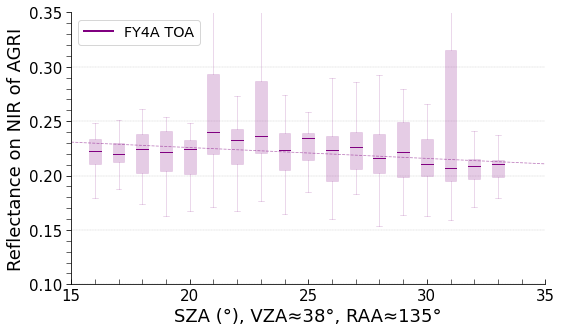

In [17]:
box_plot([v_agri_toa_record])

-0.002718045112781956 0.25982406015037596 -0.9745370234655737 3.8967621222731524e-13 0.00014740400743332296


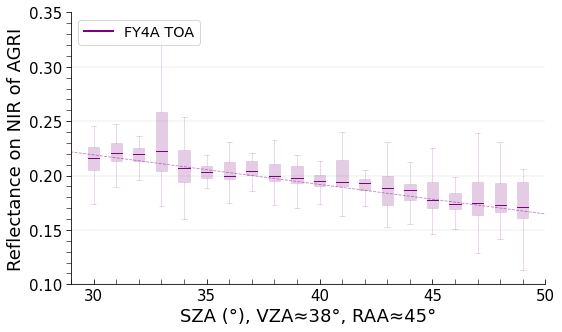

In [28]:
box_plot([v_agri_toa_record])